In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.layers import Dense
from keras.models import load_model
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.metrics import binary_accuracy
from keras.preprocessing import image

from keras.models import Model
from keras.optimizers import Adam, AdamW, Adamax
from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from pathlib import Path



In [ ]:
# !cp /kaggle/input/model10epochs/EfficientNetB0_epoch_10.keras /kaggle/working/

# Configuration

In [5]:
class CFG:
    CLASS_NAMES = [
        "Atelectasis",
        "Cardiomegaly",
        "Effusion",
        "Infiltration",
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia",
    ]
    BASE_PATH = Path("/kaggle/input/nih-chest-x-ray-14-224x224-resized")
    BASE_SPLIT_PATH = Path("/kaggle/input/datasetcsv")
    BEST_MODEL_PATH = "models/best_model.pt"
    
    EPOCHS = 20
    EPOCHS_PER_START = 10
    START_EPOCH = 10
    
    BATCH_SIZE = 64
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    COLOR_MODE = 'rgb'
    TARGET_SIZE = (224, 224)
    INTERVAL = 10
    
    CHECKPOINT_PATH_VAL_LOSS = 'model/EfficientNetB0_val_loss.keras'
    CHECKPOINT_PATH_VAL_AUC = 'model/EfficientNetB0_val_AUC.keras'
    CHECKPOINT_PATH_TRAIN_LOSS = 'model/EfficientNetB0_train_loss.keras'
    CHECKPOINT_PATH_TRAIN_AUC = 'model/EfficientNetB0_train_AUC.keras'
    CHECKPOINT_PATH_TRAIN_ACCURACY = 'model/EfficientNetB0_train_accuracy.keras'
    CHECKPOINT_PATH_VAL_ACCURACY = 'model/EfficientNetB0_val_accuracy.keras'
    CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH_VAL_LOSS)

In [6]:
train_df = pd.read_csv(f'{CFG.BASE_SPLIT_PATH}/train.csv')
val_df = pd.read_csv(f'{CFG.BASE_SPLIT_PATH}/validation.csv')
test_df = pd.read_csv(f'{CFG.BASE_SPLIT_PATH}//test.csv')
print('Train:', train_df.shape[0],'\nval:',val_df.shape[0], '\ntest:', test_df.shape[0])

Train: 79893 
val: 8654 
test: 23573


In [11]:
# ImageNet values: Define the mean and standard deviation values for normalization using ImageNet values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define a custom preprocessing function to normalize the image
def preprocess_image(img):
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(2, 2))
    #img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Apply CLAHE to the image
    #claheimage = clahe.apply(img)
    img = img / 255.0
    img = (img - mean) / std
    return img

In [ ]:
train_generator = ImageDataGenerator(
    samplewise_center=False, 
    samplewise_std_normalization=False, 
    horizontal_flip=True, 
    height_shift_range=0.1, 
    width_shift_range=0.05,
    rotation_range=5, 
    shear_range=0.1,
    zoom_range=0.05,    
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='full_path',
    y_col=CFG.CLASS_NAMES,
    target_size=CFG.TARGET_SIZE,
    color_mode=CFG.COLOR_MODE,
    class_mode='raw',
    batch_size=CFG.BATCH_SIZE
)

In [ ]:
val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='full_path',
    y_col=CFG.CLASS_NAMES,
    target_size=CFG.TARGET_SIZE,
    color_mode=CFG.COLOR_MODE,
    class_mode='raw',
    batch_size=CFG.BATCH_SIZE
)

In [ ]:
# Lấy một batch hình ảnh và nhãn từ train_generator
images, labels_encoded = next(train_generator)

# Tạo khung lưới 4x4 để hiển thị hình ảnh, với kích thước 16x16 inches
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Lặp qua từng hình ảnh, nhãn tương ứng và khung subplot
for image, label_encoded, ax in zip(images, labels_encoded, axes.flatten()):
    
    # Hiển thị hình ảnh ở kênh đầu tiên (giả sử là grayscale)
    ax.imshow(image[:, :, 0])
    
    # Tạo danh sách tên các lớp được dự đoán với xác suất > 0.5
    predicted_classes = [
        class_name for class_name, class_score in zip(CFG.CLASS_NAMES, label_encoded) 
        if class_score > 0.5
    ]
    
    # Hiển thị tên lớp dự đoán làm tiêu đề cho mỗi hình ảnh
    ax.set_title(', '.join(predicted_classes))
    
    # Tắt hiển thị trục tọa độ để tập trung vào hình ảnh
    ax.axis('off')

# Hiển thị khung hình đã tạo
plt.show()

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adamax

def build_model():
    # Load the pre-trained EfficientNetB0 model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

    # Add new trainable layers on top of the pre-trained model
    x = base_model.output

    # Add the final prediction layer
    preds = Dense(len(CFG.CLASS_NAMES), activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=preds)
    
    # Create an Adam optimizer with weight decay
    optimizer = Adamax(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC'])
    
    model.summary()    
    return model

In [ ]:
# Tạo đối tượng MirroredStrategy để phân phối đào tạo trên nhiều GPU
strategy = tf.distribute.MirroredStrategy()

# In số lượng thiết bị (GPU) mà MirroredStrategy sẽ sử dụng
print('Number of devices (GPU): {}'.format(strategy.num_replicas_in_sync))

In [ ]:
# # buiding a model inside the strategy scope
# with strategy.scope():
#     multi_gpu_model = build_model()
# #multi_gpu_model.summary()

In [ ]:
# Define the ReduceLROnPlateau & ModelCheckpoint & Early stopping callbacks
checkpoint_val_accuracy = ModelCheckpoint(CFG.CHECKPOINT_PATH_TRAIN_ACCURACY, 
                                          verbose=0, 
                                          monitor='val_accuracy', 
                                          save_best_only=True, 
                                          mode='max')

checkpoint_train_accuracy = ModelCheckpoint(CFG.CHECKPOINT_PATH_VAL_ACCURACY, 
                                            verbose=0, 
                                            monitor='val_binary_accuracy', 
                                            save_best_only=True, 
                                            mode='max')

checkpoint_val_loss = ModelCheckpoint(CFG.CHECKPOINT_PATH_VAL_LOSS, 
                                      verbose=0, 
                                      save_best_only=True)

checkpoint_val_AUC = ModelCheckpoint(CFG.CHECKPOINT_PATH_VAL_AUC, 
                                      verbose=0, 
                                      save_best_only=True, 
                                      monitor='val_AUC', 
                                      mode='max')

checkpoint_train_AUC = ModelCheckpoint(CFG.CHECKPOINT_PATH_TRAIN_AUC, 
                                        verbose=0, 
                                        save_best_only=True, 
                                        monitor='val_AUC', 
                                        mode='max')

checkpoint_train_loss = ModelCheckpoint(CFG.CHECKPOINT_PATH_TRAIN_LOSS, 
                                        verbose=0, 
                                        monitor='loss', 
                                        mode='min', 
                                        save_best_only=True)

anne = ReduceLROnPlateau(monitor='val_loss', 
                         factor=0.1, 
                         patience=2, 
                         verbose=1, 
                         min_lr=1e-7)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               verbose=1, 
                               mode='min')


# Input & Training

In [ ]:
def load_or_train_model(start_epoch = CFG.START_EPOCH):
    model_path = f'/kaggle/input/model{start_epoch}epochs/EfficientNetB0_epoch_{start_epoch}.keras'
    if os.path.exists(model_path):
        print(f'Loading model from {model_path}')
        multi_gpu_model = tf.keras.models.load_model(model_path)
    else:
        print(f'Model not found. Training from scratch.')
        multi_gpu_model = build_model()  # Huấn luyện từ đầu
    return multi_gpu_model

In [ ]:
with strategy.scope():
    multi_gpu_model = load_or_train_model(CFG.START_EPOCH)

In [ ]:
def plot_history(history, epoch_start, epoch_end):
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss from epoch {epoch_start} to {epoch_end}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # AUC
    plt.subplot(1, 2, 2)
    plt.plot(history.history['AUC'], label='Train AUC')
    plt.plot(history.history['val_AUC'], label='Validation AUC')
    plt.title(f'AUC from epoch {epoch_start} to {epoch_end}')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.savefig(f'training_history_{epoch_start}_to_{epoch_end}.png')
    plt.show()

In [ ]:
for i in range(CFG.START_EPOCH, CFG.EPOCHS, CFG.EPOCHS_PER_START):
    end_epoch = min(i + CFG.EPOCHS_PER_START, CFG.EPOCHS)
    
    print(f'Training from epoch {i+1} to {end_epoch}')
    
    # Huấn luyện mô hình trong từng phần nhỏ
    history = multi_gpu_model.fit(
        train_generator,
        epochs=end_epoch,
        initial_epoch=i,
        callbacks=[anne,
                   checkpoint_val_loss, checkpoint_val_AUC,
                   checkpoint_train_loss, checkpoint_train_AUC,
                   checkpoint_val_accuracy, checkpoint_train_accuracy],
        validation_data=val_generator,
    )

    
    model_path = f'EfficientNetB0_epoch_{end_epoch}.keras'
    multi_gpu_model.save(model_path)
    print(f'Model saved after epoch {end_epoch} at {model_path}')

    plot_history(history, i+1, end_epoch)

# Import Trained model

In [12]:
load_model = tf.keras.models.load_model("/kaggle/input/model20epochs/EfficientNetB0_epoch_20.keras")

In [13]:

# Smaller batch size to fit within memory constraints
batch_size = 512

# Adjust the test generator with the new batch size
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='full_path',
    y_col=CFG.CLASS_NAMES,
    target_size=CFG.TARGET_SIZE,
    color_mode=CFG.COLOR_MODE,
    class_mode='raw',
    batch_size=CFG.BATCH_SIZE,
    shuffle=False  # Ensure data order is consistent
)

Found 23573 validated image filenames.


In [14]:
def ROC_AUC (model):
    y_preds = []
    y_trues = []

    # Iterate over the test generator and collect predictions
    for _ in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch, verbose=0)
        y_preds.append(y_pred_batch)
        y_trues.append(y_batch)

    # Concatenate all batches together
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)

    # Extract class labels from the dataframe columns
    class_labels = test_df[CFG.CLASS_NAMES].columns

    # Compute the ROC AUC score for each class
    roc_auc_scores = {}
    for i, label in enumerate(class_labels):
        auc = roc_auc_score(y_trues[:, i], y_preds[:, i])
        roc_auc_scores[label] = auc

    # Print the ROC AUC scores
    for label, auc in roc_auc_scores.items():
        print(f"ROC AUC Score for {label}: {auc:.4f}")

    # Calculate and print the average ROC AUC score
    average_roc_auc = np.mean(list(roc_auc_scores.values()))
    print(f"Average ROC AUC Score: {average_roc_auc:.4f}")

In [16]:
ROC_AUC(load_model)
#load_dense121_model=0

ROC AUC Score for Atelectasis: 0.8121
ROC AUC Score for Cardiomegaly: 0.9049
ROC AUC Score for Effusion: 0.8829
ROC AUC Score for Infiltration: 0.7119
ROC AUC Score for Mass: 0.8358
ROC AUC Score for Nodule: 0.7430
ROC AUC Score for Pneumonia: 0.7489
ROC AUC Score for Pneumothorax: 0.8772
ROC AUC Score for Consolidation: 0.7986
ROC AUC Score for Edema: 0.8905
ROC AUC Score for Emphysema: 0.9016
ROC AUC Score for Fibrosis: 0.8032
ROC AUC Score for Pleural_Thickening: 0.7916
ROC AUC Score for Hernia: 0.9260
Average ROC AUC Score: 0.8306


In [17]:
from keras.models import load_model

def evaluate_model(paths):
    results = {}
    
    for name, path in paths.items():
        model = load_model(path)
        auc = ROC_AUC(model)
        results[name] = auc
        print(f"{name} = {auc}")
    
    return results

# Define the paths for each model
model_paths = {
    "model_train_loss": '/kaggle/input/model20epochs/model/EfficientNetB0_train_loss.keras',
    "model_train_AUC": '/kaggle/input/model20epochs/model/EfficientNetB0_train_AUC.keras',
    "model_val_loss": '/kaggle/input/model20epochs/model/EfficientNetB0_val_loss.keras',
    "model_val_AUC": '/kaggle/input/model20epochs/model/EfficientNetB0_val_AUC.keras',
}

results = evaluate_model(model_paths)


ROC AUC Score for Atelectasis: 0.8120
ROC AUC Score for Cardiomegaly: 0.9048
ROC AUC Score for Effusion: 0.8829
ROC AUC Score for Infiltration: 0.7119
ROC AUC Score for Mass: 0.8361
ROC AUC Score for Nodule: 0.7432
ROC AUC Score for Pneumonia: 0.7491
ROC AUC Score for Pneumothorax: 0.8773
ROC AUC Score for Consolidation: 0.7988
ROC AUC Score for Edema: 0.8904
ROC AUC Score for Emphysema: 0.9018
ROC AUC Score for Fibrosis: 0.8032
ROC AUC Score for Pleural_Thickening: 0.7914
ROC AUC Score for Hernia: 0.9268
Average ROC AUC Score: 0.8307
model_train_loss = None
ROC AUC Score for Atelectasis: 0.8120
ROC AUC Score for Cardiomegaly: 0.9048
ROC AUC Score for Effusion: 0.8829
ROC AUC Score for Infiltration: 0.7120
ROC AUC Score for Mass: 0.8357
ROC AUC Score for Nodule: 0.7427
ROC AUC Score for Pneumonia: 0.7490
ROC AUC Score for Pneumothorax: 0.8770
ROC AUC Score for Consolidation: 0.7986
ROC AUC Score for Edema: 0.8905
ROC AUC Score for Emphysema: 0.9013
ROC AUC Score for Fibrosis: 0.8030
RO

# **Metrices**

In [18]:
model_val_AUC = load_model('/kaggle/input/model20epochs/model/EfficientNetB0_val_AUC.keras')

In [19]:
# Initialize arrays to store predictions and true labels
y_preds = []
y_trues = []

In [20]:
# Iterate over the test generator and collect predictions
for _ in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    y_pred_batch = model_val_AUC.predict(x_batch, verbose =0)
    y_preds.append(y_pred_batch)
    y_trues.append(y_batch)

In [21]:
# Convert lists to numpy arrays for slicing
y_preds = np.vstack(y_preds)  # Stack predictions vertically
y_trues = np.vstack(y_trues)  # Stack ground truth labels vertically

In [22]:
from sklearn.metrics import roc_auc_score

# Compute the ROC AUC score for each class
roc_auc_scores = {}
for i, label in enumerate(CFG.CLASS_NAMES):
    auc = roc_auc_score(y_trues[:, i], y_preds[:, i])
    roc_auc_scores[label] = auc

# Print the ROC AUC scores
for label, auc in roc_auc_scores.items():
    print(f"ROC AUC Score for {label}: {auc:.4f}")

# Calculate and print the average ROC AUC score
average_roc_auc = np.mean(list(roc_auc_scores.values()))
print(f"Average ROC AUC Score: {average_roc_auc:.4f}")

ROC AUC Score for Atelectasis: 0.8120
ROC AUC Score for Cardiomegaly: 0.9048
ROC AUC Score for Effusion: 0.8829
ROC AUC Score for Infiltration: 0.7120
ROC AUC Score for Mass: 0.8357
ROC AUC Score for Nodule: 0.7427
ROC AUC Score for Pneumonia: 0.7490
ROC AUC Score for Pneumothorax: 0.8770
ROC AUC Score for Consolidation: 0.7986
ROC AUC Score for Edema: 0.8905
ROC AUC Score for Emphysema: 0.9013
ROC AUC Score for Fibrosis: 0.8030
ROC AUC Score for Pleural_Thickening: 0.7912
ROC AUC Score for Hernia: 0.9262
Average ROC AUC Score: 0.8305


Micro-Average ROC AUC Score: 0.8779


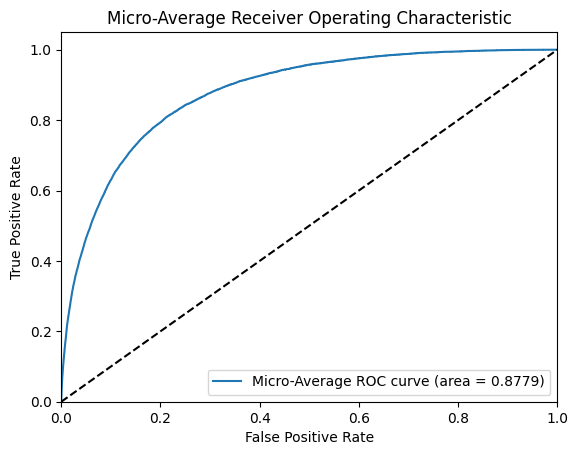

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute the ROC AUC score (micro-average)
roc_auc_micro = roc_auc_score(y_trues, y_preds, average='micro')
print(f"Micro-Average ROC AUC Score: {roc_auc_micro:.4f}")

# Compute the ROC curve (micro-average)
fpr, tpr, _ = roc_curve(y_trues.ravel(), y_preds.ravel())

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Micro-Average ROC curve (area = {roc_auc_micro:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Save the figure
plt.savefig('Micro-Average-ROC.png', bbox_inches='tight')

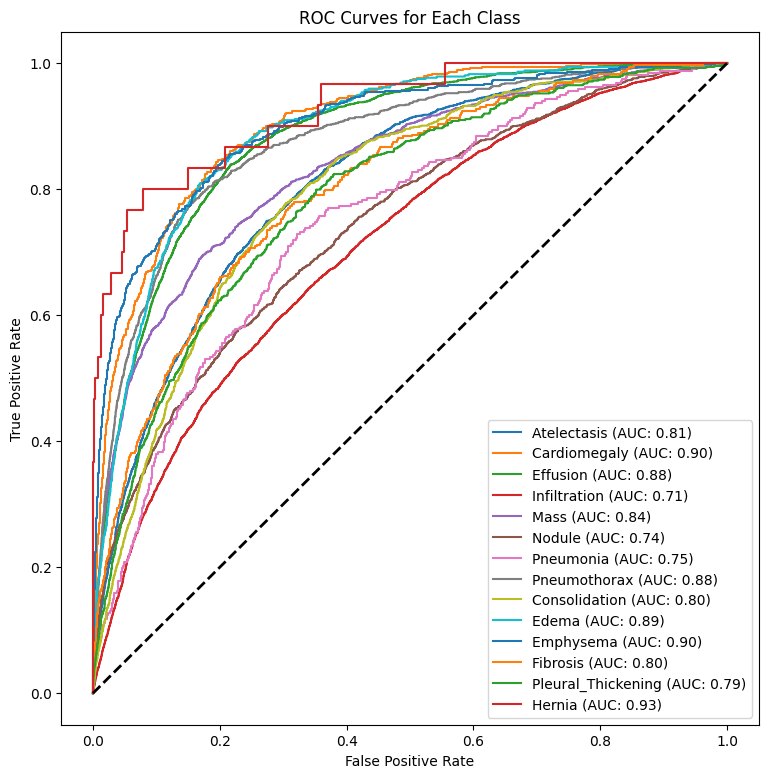

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_trues and y_preds are already defined
# class_labels should be a list of class names

# Plot ROC curves for each class
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(CFG.CLASS_NAMES):
    fpr, tpr, thresholds = roc_curve(y_trues[:, idx], y_preds[:, idx])
    auc_score = auc(fpr, tpr)
    c_ax.plot(fpr, tpr, label=f'{c_label} (AUC: {auc_score:.2f})')

# Plotting the diagonal line
c_ax.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot labels and title
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('ROC Curves for Each Class')
c_ax.legend(loc='best')

# Save the figure
fig.savefig('ROC Curves.png')
plt.show()

In [ ]:
# !rm -rf /kaggle/working/*

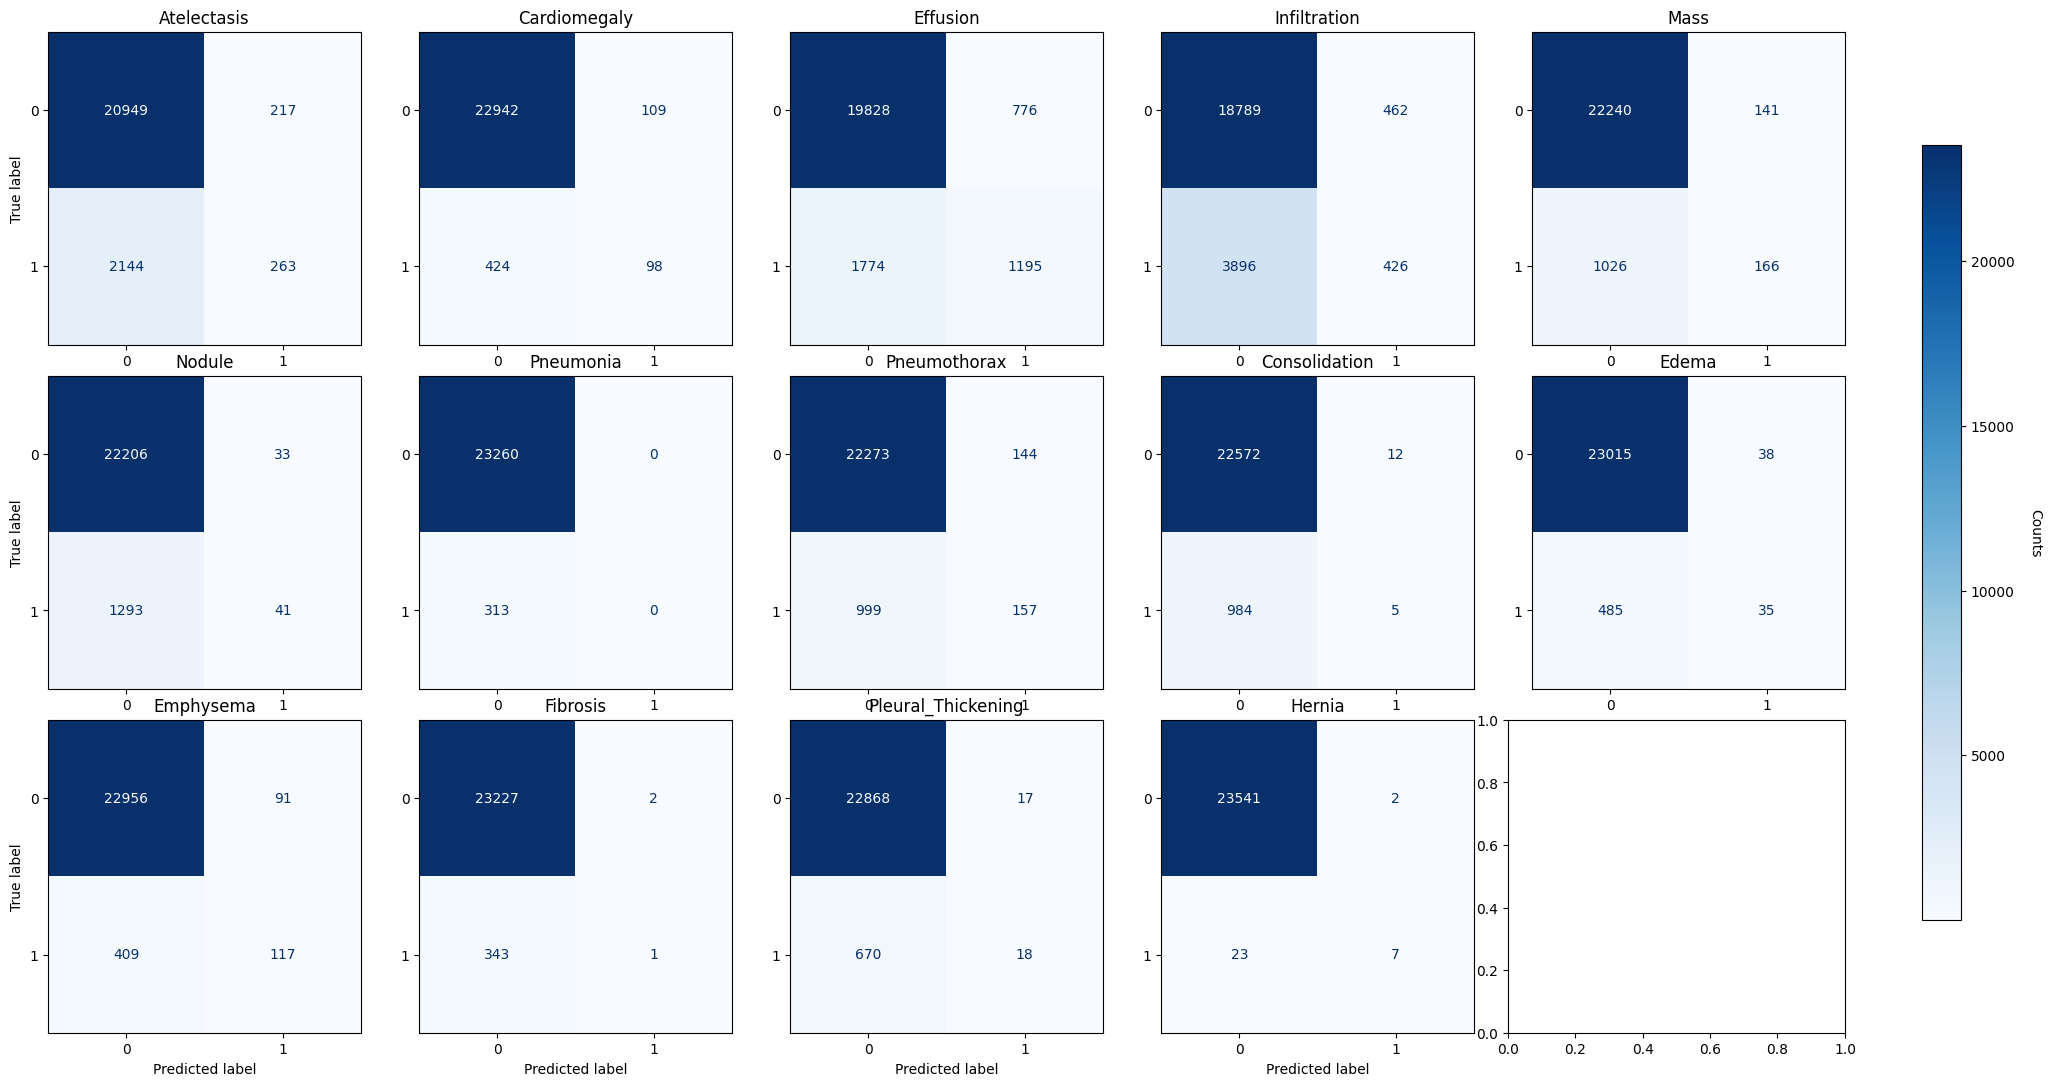

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt

# Assume y_preds and y_trues are already defined as above
y_pred = (y_preds > 0.5).astype(int)
y_true = y_trues

# Calculate the confusion matrix for each label
cm = multilabel_confusion_matrix(y_true, y_pred)

# Set the figure size and create subplots
f, axes = plt.subplots(3, 5, figsize=(25, 13))
axes = axes.ravel()

# Loop through each class label
for i in range(len(CFG.CLASS_NAMES)):
    # Create the confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i], y_pred[:, i]),
                                  display_labels=[0, 1])  # Assuming binary labels (0, 1)
    # Set the color map to 'Blues' and float the colorbar
    disp.plot(ax=axes[i], values_format='d', cmap='Blues')  # Change to '.2f' for two decimal places
    disp.ax_.set_title(CFG.CLASS_NAMES[i])

    # Adjust axis labels
    if i < 10:
        disp.ax_.set_xlabel('')
    if i % 5 != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()  # Remove the individual colorbar

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.10, hspace=0.1)

# Add a single, shared colorbar
cbar = f.colorbar(disp.im_, ax=axes, location='right', fraction=0.02, pad=0.04)
cbar.ax.set_ylabel('Counts', rotation=270, labelpad=20)

# Save the plot as a PNG file
plt.savefig('confusion_matrix.png', bbox_inches='tight')

<Figure size 3000x2800 with 0 Axes>

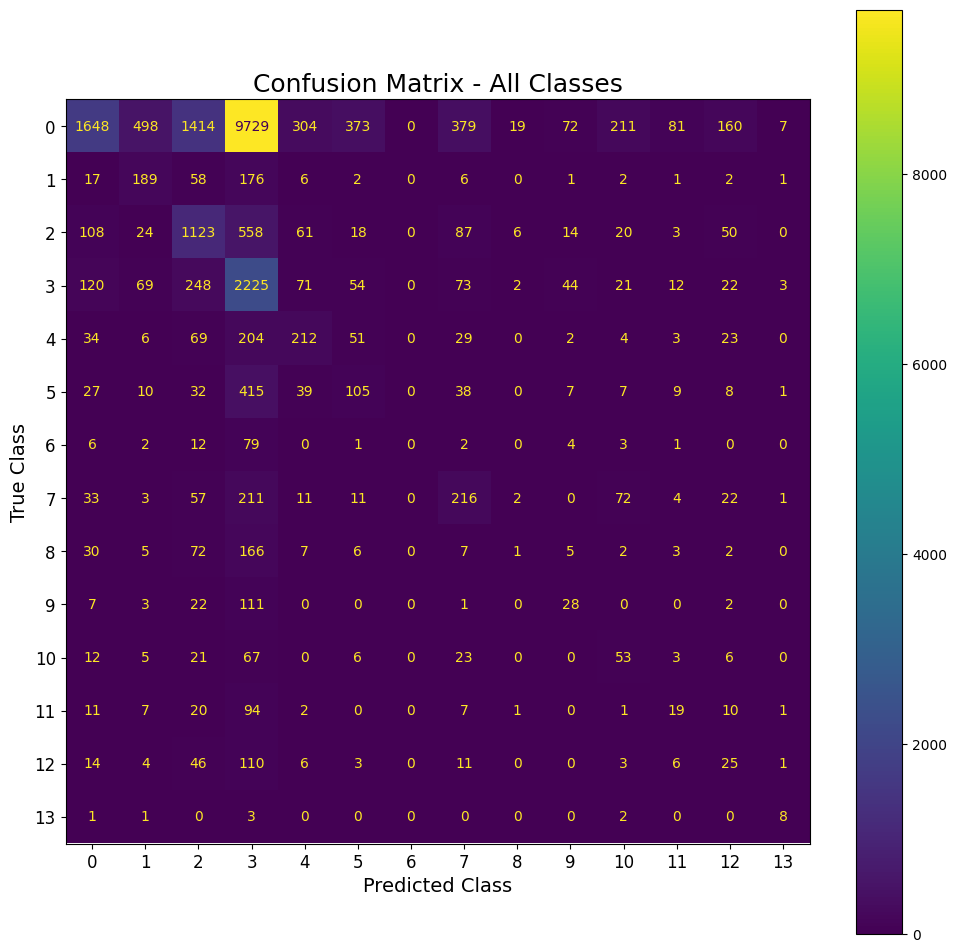

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_true and y_preds should be one-hot encoded or label-encoded class-wise predictions
# Assuming y_preds and y_trues are defined

# Convert the one-hot encoded labels to single label for each sample
y_true_single = np.argmax(y_trues, axis=1)
y_pred_single = np.argmax(y_preds, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true_single, y_pred_single)

# Increase figure size for larger cells
plt.figure(figsize=(30, 28))  # Increase the figure size

# Create the ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
fig, ax = plt.subplots(figsize=(12,12))
# Plot the confusion matrix with larger text
disp.plot(cmap='viridis', values_format='d', ax=ax, )  # values_format='d' for integer format

# Increase font size for labels and title
plt.title('Confusion Matrix - All Classes', fontsize=18)  # Larger title
plt.xlabel('Predicted Class', fontsize=14)  # Larger x-axis label
plt.ylabel('True Class', fontsize=14)  # Larger y-axis label
plt.xticks(fontsize=12)  # Larger x-axis ticks
plt.yticks(fontsize=12)  # Larger y-axis ticks

# Save and display the plot
plt.savefig('unified_confusion_matrix_large_cells.png', bbox_inches='tight')
plt.show()


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
y_pred_classes = np.where(y_preds > 0.5, 1, 0)  # Assuming binary classification

In [28]:
# Initialize dictionaries to hold scores per class
precision_scores = {}
recall_scores = {}
f1_scores = {}
accuracy_scores = {}

# Extract class labels from the dataframe columns
class_labels = test_df[CFG.CLASS_NAMES].columns

for i, label in enumerate(class_labels):
    precision = precision_score(y_trues[:, i], y_pred_classes[:, i])
    recall = recall_score(y_trues[:, i], y_pred_classes[:, i])
    f1 = f1_score(y_trues[:, i], y_pred_classes[:, i])
    accuracy = accuracy_score(y_trues[:, i], y_pred_classes[:, i])
    
    # Store the scores
    precision_scores[label] = precision
    recall_scores[label] = recall
    f1_scores[label] = f1
    accuracy_scores[label] = accuracy

# Print the metrics for each class
for label in class_labels:
    print(f"{label} - Precision: {precision_scores[label]:.4f}, Recall: {recall_scores[label]:.4f}, F1 Score: {f1_scores[label]:.4f}, Accuracy: {accuracy_scores[label]:.4f}")

Atelectasis - Precision: 0.5479, Recall: 0.1093, F1 Score: 0.1822, Accuracy: 0.8998
Cardiomegaly - Precision: 0.4734, Recall: 0.1877, F1 Score: 0.2689, Accuracy: 0.9774
Effusion - Precision: 0.6063, Recall: 0.4025, F1 Score: 0.4838, Accuracy: 0.8918
Infiltration - Precision: 0.4797, Recall: 0.0986, F1 Score: 0.1635, Accuracy: 0.8151
Mass - Precision: 0.5407, Recall: 0.1393, F1 Score: 0.2215, Accuracy: 0.9505
Nodule - Precision: 0.5541, Recall: 0.0307, F1 Score: 0.0582, Accuracy: 0.9437
Pneumonia - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9867
Pneumothorax - Precision: 0.5216, Recall: 0.1358, F1 Score: 0.2155, Accuracy: 0.9515
Consolidation - Precision: 0.2941, Recall: 0.0051, F1 Score: 0.0099, Accuracy: 0.9577
Edema - Precision: 0.4795, Recall: 0.0673, F1 Score: 0.1180, Accuracy: 0.9778
Emphysema - Precision: 0.5625, Recall: 0.2224, F1 Score: 0.3188, Accuracy: 0.9788
Fibrosis - Precision: 0.3333, Recall: 0.0029, F1 Score: 0.0058, Accuracy: 0.9854
Pleural_Thicken

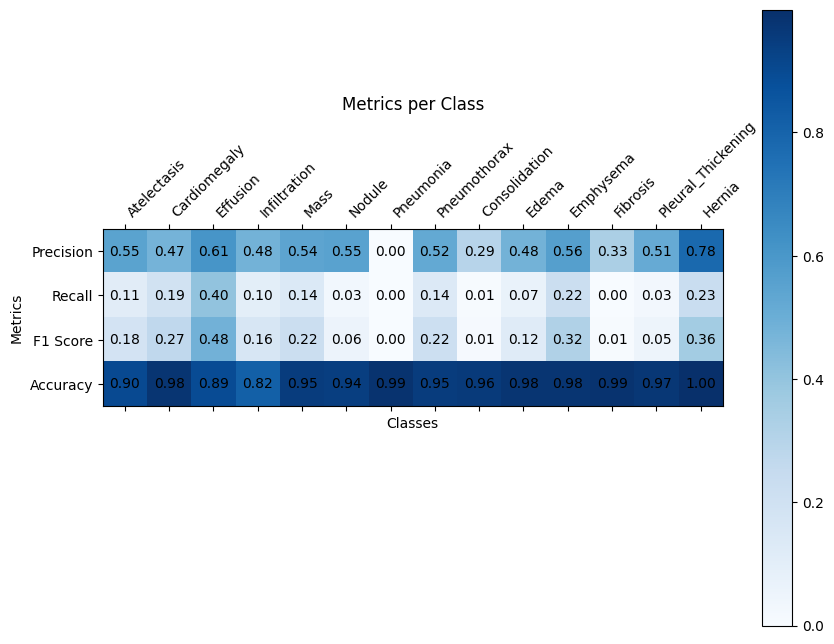

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming precision_scores, recall_scores, f1_scores, and accuracy_scores are already calculated

# Extract class labels from the dictionary keys
class_labels = list(precision_scores.keys())

# Combine all metrics into a single matrix
metrics_matrix = np.array([
    list(precision_scores.values()),
    list(recall_scores.values()),
    list(f1_scores.values()),
    list(accuracy_scores.values())
])

# Define the metric names
metric_names = ['Precision', 'Recall', 'F1 Score', 'Accuracy']

# Plotting the metrics in a matrix-style grid
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(metrics_matrix, cmap='Blues')

# Add color bar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(metric_names)))

# Label the axes with class names and metric names
ax.set_xticklabels(class_labels, rotation=45, ha="left")
ax.set_yticklabels(metric_names)

# Loop over data dimensions and create text annotations
for i in range(len(metric_names)):
    for j in range(len(class_labels)):
        ax.text(j, i, f'{metrics_matrix[i, j]:.2f}', ha='center', va='center', color='black')

# Set titles and layout
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.title('Metrics per Class')
fig.savefig('Metrics per Class.png')
plt.show()

In [30]:
avg_precision = np.mean(list(precision_scores.values()))
avg_recall = np.mean(list(recall_scores.values()))
avg_f1 = np.mean(list(f1_scores.values()))
avg_accuracy = np.mean(list(accuracy_scores.values()))

print(f"\nAverage Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")


Average Precision: 0.4775
Average Recall: 0.1186
Average F1 Score: 0.1754
Average Accuracy: 0.9490


In [31]:
roc_auc_scores = {}
for i, label in enumerate(class_labels):
    auc = roc_auc_score(y_trues[:, i], y_preds[:, i])
    roc_auc_scores[label] = auc

# Print the ROC AUC scores
for label, auc in roc_auc_scores.items():
    print(f"ROC AUC Score for {label}: {auc:.4f}")

# Calculate and print the average ROC AUC score
average_roc_auc = np.mean(list(roc_auc_scores.values()))
print(f"Average ROC AUC Score: {average_roc_auc:.4f}")

ROC AUC Score for Atelectasis: 0.8120
ROC AUC Score for Cardiomegaly: 0.9048
ROC AUC Score for Effusion: 0.8829
ROC AUC Score for Infiltration: 0.7120
ROC AUC Score for Mass: 0.8357
ROC AUC Score for Nodule: 0.7427
ROC AUC Score for Pneumonia: 0.7490
ROC AUC Score for Pneumothorax: 0.8770
ROC AUC Score for Consolidation: 0.7986
ROC AUC Score for Edema: 0.8905
ROC AUC Score for Emphysema: 0.9013
ROC AUC Score for Fibrosis: 0.8030
ROC AUC Score for Pleural_Thickening: 0.7912
ROC AUC Score for Hernia: 0.9262
Average ROC AUC Score: 0.8305


# Util function

In [32]:
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1

# Grad-CAM

In [33]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer as well as the output predictions
    grad_model = Model(
        inputs=[model.input], 
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Record the operations to compute the gradient of the predicted class
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute the gradient of the output with respect to the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the gradients with the output feature map
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [34]:
def display_gradcam(img_path, heatmap, alpha=0.5):
    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img)

    # Rescale the heatmap between 0 and 255
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap jet to heatmap
    jet = plt.cm.get_cmap("jet")

    # Get RGB values from the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image from the colored heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    return superimposed_img


In [35]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)  # Preprocess for DenseNet121

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


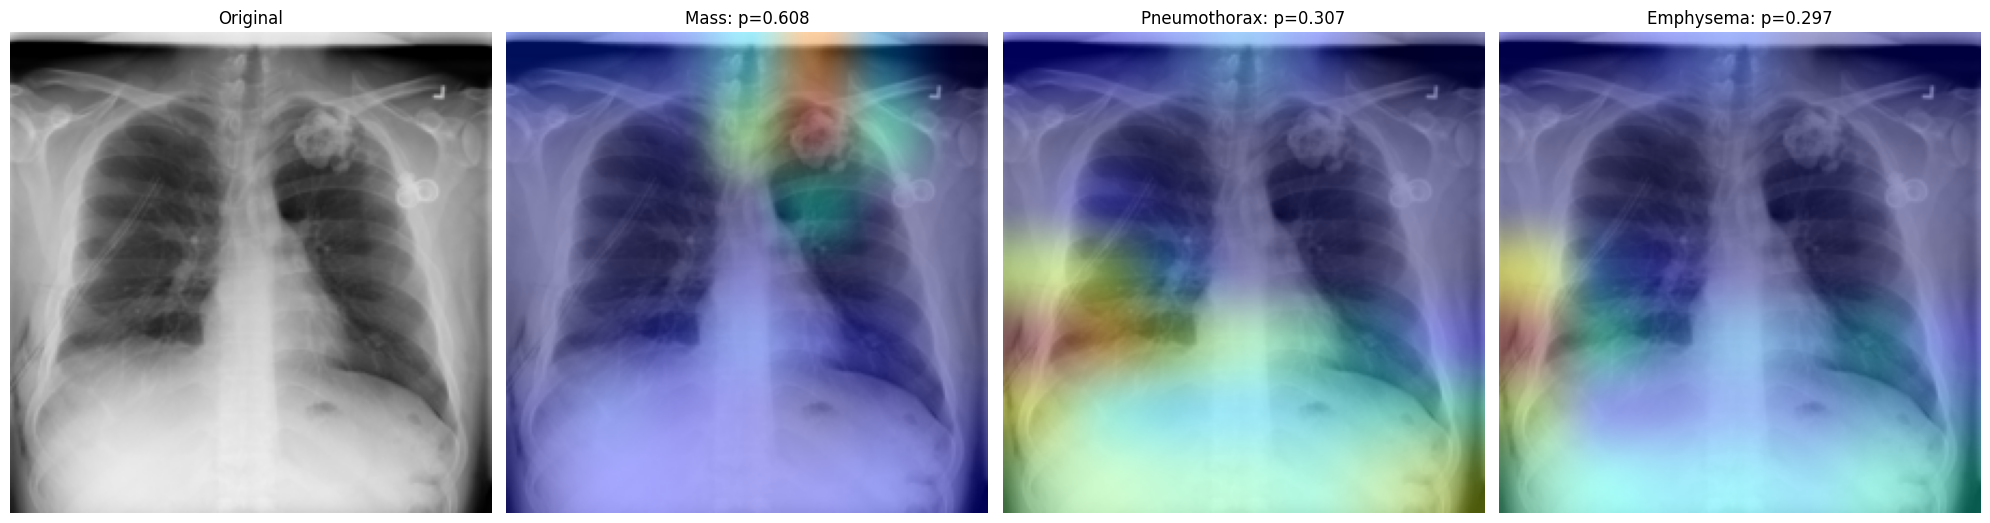

In [40]:
def plot_top3_predictions_with_gradcam(model, img_path, last_conv_layer_name, labels, top=3):
    # Load and preprocess the image
    img_array = get_img_array(img_path, size=(224, 224))

    # Make predictions
    preds = model.predict(img_array)

    # Get top 4 predicted indices and probabilities
    top_indices = preds[0].argsort()[-top:][::-1]
    top_probs = preds[0][top_indices]

    plt.figure(figsize=(20, 10))
    
    # Display original image
    plt.subplot(1, top+1, 1)
    img = load_img(img_path)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    # Generate and display Grad-CAM for the top predictions
    for i, (index, prob) in enumerate(zip(top_indices, top_probs), 2):
        # Generate Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=index)

        # Display Grad-CAM
        plt.subplot(1, top+1, i)
        superimposed_img = display_gradcam(img_path, heatmap)
        plt.imshow(superimposed_img)
        plt.title(f"{labels[index]}: p={prob:.3f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


img_path = '/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224/00011355_002.png'

last_conv_layer_name = 'top_conv'
plot_top3_predictions_with_gradcam(model_val_AUC, img_path, last_conv_layer_name, CFG.CLASS_NAMES)


# Testing